<a href="https://colab.research.google.com/github/ekaterinatao/house_md_tg_bot/blob/main/notebooks/NLP_2_HW1_house_md_bot_cross_encoder_from_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cross-Encoder BERT
За основу взят ноутбук с семинара.  
Finetune модели BERT для задачи реранкинга проводился на датасете `glue, stsb`.  
Отчет обучения на [wandb](https://api.wandb.ai/links/taoea/bqacdqvy).  
Сохраненный чекпойнт дообученной модели на [huggingface](https://huggingface.co/ekaterinatao/house-md-bot-bert-cross-encoder).

* Для инференса использовался предобработанный [датасет](https://huggingface.co/datasets/ekaterinatao/house_md_context3) с репликами из сериала, содержащий только положительные примеры.  
* С помощью Bi-Encoder входящий запрос преобразовывали в эмбеддинг. С помощью быстрого поиска из библиотеки faiss происходил выбор топ k ответов, на основании схожести подаваемого запроса и контекста ответов Доктора Хауса.  
* База из топ k лучших ответов Доктора Хауса вместе с входящим запросом подавались в Cross-Encoder для реранкинга.   



In [1]:
!pip install transformers accelerate>=0.21.0 datasets wandb faiss-cpu -q -U

In [2]:
import random
import re
from glob import glob
from tqdm import tqdm
import faiss
from typing import Callable, Iterable
from dataclasses import dataclass
import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
import wandb

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
seed = 64

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
dataset = datasets.load_dataset("glue", "stsb", split="train")
dataset

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 5749
})

In [ ]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer([data["sentence1"] for data in dataset],
                            [data["sentence2"] for data in dataset],
                            max_length=MAX_LENGTH, padding="max_length",
                            truncation=True, verbose=True)

CPU times: user 1.7 s, sys: 350 ms, total: 2.05 s
Wall time: 845 ms


In [ ]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(self.tokens["attention_mask"][ix], dtype=torch.long),
            "labels": torch.tensor(self.labels[ix], dtype=torch.float)  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [ ]:
%%time

sts_dataset = StsDataset(tokenized_texts, [data["label"] for data in dataset])

CPU times: user 199 ms, sys: 3.53 ms, total: 203 ms
Wall time: 200 ms


In [ ]:
train_ratio = 0.8
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_dataloader), len(val_dataloader)

(288, 72)

In [ ]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [ ]:
model = CrossEncoderBert().to(device)

In [ ]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [ ]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()

def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()


def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    for i, batch in enumerate(dataloader):
        if is_training:
            loss = train_step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = val_step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
            if is_training:
                wandb.log({"step": i, "train_loss":loss})
            else:
                wandb.log({"step": i, "val_loss":loss})

    return np.mean(mini_batch_losses), mini_batch_losses

In [ ]:
wandb_config = {
    "model": 'distilbert-base-uncased',
    "dataset": "glue, stsb",
    "token_length": MAX_LENGTH,
    "batch_size": batch_size,
    "learning_rate": 3e-5,
    "num_epochs": 2,
    "optimizer": optimizer,
    "loss_fn": loss_fn
}
wandb.init(
    project='house-md-bot-cross-encoder',
    notes='2 epoch, glue data from seminar',
    config=wandb_config
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Запустим обучение нашей модели

In [ ]:
n_epochs = 2

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, is_training=True)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1

Training ...
Step     0/288, Loss = 6.484
Step    64/288, Loss = 1.815
Step   128/288, Loss = 0.684
Step   192/288, Loss = 0.684
Step   256/288, Loss = 1.596

Validating ...
Step     0/72, Loss = 1.393
Step    64/72, Loss = 0.568

Epoch 2

Training ...
Step     0/288, Loss = 0.156
Step    64/288, Loss = 0.354
Step   128/288, Loss = 0.857
Step   192/288, Loss = 0.518
Step   256/288, Loss = 0.440

Validating ...
Step     0/72, Loss = 1.393
Step    64/72, Loss = 0.568


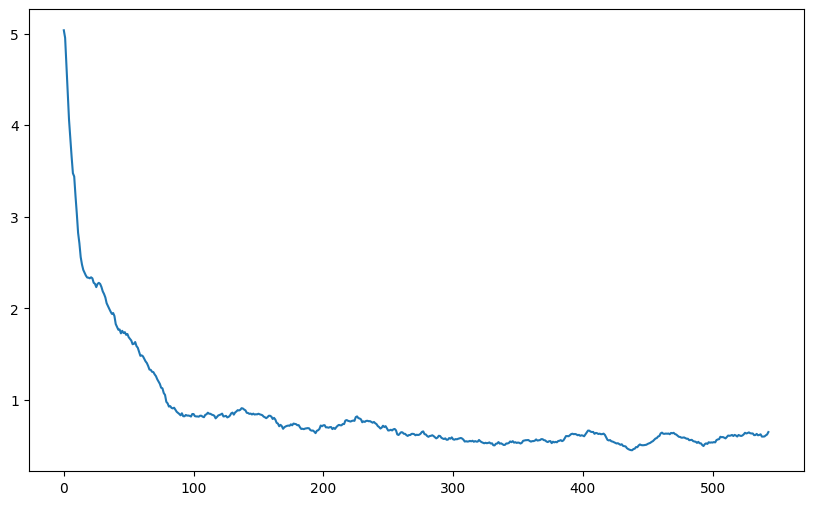

In [ ]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

fix, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH='/content/drive/MyDrive/models/house-md-bot-cross-encoder'

In [ ]:
model.bert_model.save_pretrained(PATH)

In [ ]:
model.bert_tokenizer.save_pretrained(PATH)

('/content/drive/MyDrive/models/house-md-bot-cross-encoder/tokenizer_config.json',
 '/content/drive/MyDrive/models/house-md-bot-cross-encoder/special_tokens_map.json',
 '/content/drive/MyDrive/models/house-md-bot-cross-encoder/vocab.txt',
 '/content/drive/MyDrive/models/house-md-bot-cross-encoder/added_tokens.json',
 '/content/drive/MyDrive/models/house-md-bot-cross-encoder/tokenizer.json')

In [ ]:
def get_ranked_docs(
    tokenizer: AutoTokenizer, finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel, query: str, corpus: list[str]
) -> None:

    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries, corpus, max_length=MAX_LENGTH, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(tokenized_texts['input_ids'], tokenized_texts['attention_mask']).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :]))  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [ ]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey."
]

query = "A man is eating pasta."

In [ ]:
get_ranked_docs(tokenizer, model, bert_model.to(device), query, corpus)

Query - A man is eating pasta. [Finetuned Cross-Encoder]
---
0.95	A man is eating food.
0.92	A man is eating a piece of bread.
0.58	A man is riding a horse.
0.56	Two men pushed carts through the woods.
0.55	A cheetah is running behind its prey.
0.55	A man is riding a white horse on an enclosed ground.
0.52	The girl is carrying a baby.
0.50	A monkey is playing drums.
0.48	A woman is playing violin.

Query - A man is eating pasta. [Bert Base]
---
0.51	A man is eating food.
0.50	A man is eating a piece of bread.
0.50	A woman is playing violin.
0.50	A monkey is playing drums.
0.50	A man is riding a horse.
0.49	A cheetah is running behind its prey.
0.49	The girl is carrying a baby.
0.49	Two men pushed carts through the woods.
0.49	A man is riding a white horse on an enclosed ground.


Предобученная на семинаре модель ранжирует лучше, чем исходный BERT.

# Подготовка бызы cls векторов датасета из сериала

In [ ]:
# # загрузка CLS векторов для всех вопросов с контекстом, полученных би-энкодером
# qc_base = np.load("/content/drive/MyDrive/data/house_md/qc_base.npy", allow_pickle=True)
# # Оставляем вопрос+контекст только для положительных примеров
# qc_base_house = qc_base[:len(house_data)]

In [ ]:
# np.save("/content/drive/MyDrive/data/house_md/qc_base_house", qc_base_house, allow_pickle=True)

In [58]:
qc_base_house = np.load("/content/drive/MyDrive/data/house_md/qc_base_house.npy", allow_pickle=True)
qc_base_house.shape

(65088, 768)

In [59]:
embeds = []
for embed in qc_base_house:
    embeds.append(embed)
len(embeds)

65088

In [61]:
qc_dataset = datasets.Dataset.from_pandas(
    pd.DataFrame({'cls_embeds': embeds}).reset_index(drop=True)
)
qc_dataset = qc_dataset.with_format("np")
qc_dataset

Dataset({
    features: ['cls_embeds'],
    num_rows: 65088
})

In [63]:
from huggingface_hub import notebook_login
notebook_login()

In [64]:
qc_dataset.push_to_hub("ekaterinatao/house_md_cls_embeds", private=False)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/66 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ekaterinatao/house_md_cls_embeds/commit/6cd590aa85f8376137e0434faf944babb397a1bf', commit_message='Upload dataset', commit_description='', oid='6cd590aa85f8376137e0434faf944babb397a1bf', pr_url=None, pr_revision=None, pr_num=None)

# Инференс

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка датасета и фильтрация только положительных примеров

In [4]:
dataset = datasets.load_dataset('ekaterinatao/house_md_context3', split='train')
dataset

Generating train split:   0%|          | 0/77505 [00:00<?, ? examples/s]

Dataset({
    features: ['answer', 'question', 'context', 'labels', 'joined'],
    num_rows: 77505
})

In [5]:
%%time
house_dataset = dataset.filter(lambda example: example['labels'] == 0)
house_dataset

Filter:   0%|          | 0/77505 [00:00<?, ? examples/s]

CPU times: user 1.96 s, sys: 43.7 ms, total: 2 s
Wall time: 6.51 s


Dataset({
    features: ['answer', 'question', 'context', 'labels', 'joined'],
    num_rows: 65088
})

In [ ]:
# house_dataset = []
# for data in tqdm(dataset):
#     if data['labels'] == 0:
#         house_dataset.append(data)
# len(house_dataset)

100%|██████████| 77505/77505 [00:07<00:00, 10157.99it/s]


65088

In [ ]:
# pd.DataFrame(house_dataset).to_csv(
#     '/content/drive/MyDrive/data/house_md/house_dataset.gz',
#     compression="gzip", index=False
# )

Загрузка предобученных моделей

In [13]:
%%time
bi_enc_finetuned = 'ekaterinatao/house-md-bot-bert-bi-encoder'
bi_model = AutoModel.from_pretrained(bi_enc_finetuned)
bi_tok = AutoTokenizer.from_pretrained(bi_enc_finetuned)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

CPU times: user 2.05 s, sys: 761 ms, total: 2.81 s
Wall time: 4.73 s


In [36]:
%%time
cross_enc_finetuned = 'ekaterinatao/house-md-bot-bert-cross-encoder'
ce_model = AutoModel.from_pretrained(cross_enc_finetuned)
ce_tok = AutoTokenizer.from_pretrained(cross_enc_finetuned)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

CPU times: user 1.04 s, sys: 908 ms, total: 1.95 s
Wall time: 6.36 s


Загрузка CLS векторов контекста

In [7]:
cls_dataset = datasets.load_dataset("ekaterinatao/house_md_cls_embeds", split='train')
cls_dataset

Generating train split:   0%|          | 0/65088 [00:00<?, ? examples/s]

Dataset({
    features: ['cls_embeds'],
    num_rows: 65088
})

In [9]:
%%time
cls_base = np.stack([embed['cls_embeds'] for embed in cls_dataset])

CPU times: user 40.7 s, sys: 4.51 s, total: 45.2 s
Wall time: 50.5 s


Реализация функции поиска лучшего ответа, описанная в начале ноутбука

In [56]:
def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeds = model_output.last_hidden_state[:, 0, :]
    embeds = torch.nn.functional.normalize(embeds)
    return embeds[0].cpu().numpy()

In [58]:
def get_ranked_docs(
    query: str, vec_query_base: np.array, data: pd.DataFrame,
    bi_model: AutoModel, bi_tok: AutoTokenizer,
    cross_model: AutoModel, cross_tok: AutoTokenizer
) -> None:

    vec_shape = vec_query_base.shape[1]
    index = faiss.IndexFlatL2(vec_shape)
    index.add(vec_query_base)
    xq = embed_bert_cls(query, bi_model, bi_tok)
    D, I = index.search(xq.reshape(1, vec_shape), 50)
    corpus = [data[int(i)]['answer'] for i in I[0]]

    ##### print ######
    print(f"Query - {query} [Bi-Encoder]\n---")
    lim = 0
    for i, j in enumerate(I[0]):
        lim += 1
        if lim == 5: break
        print(round(D[0][i], 3), data['answer'][j])
    ##### end ######

    queries = [query] * len(corpus)
    tokenized_texts = cross_tok(
        queries, corpus, max_length=128, padding=True, truncation=True, return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        model_output = cross_model(
            **{k: v.to(cross_model.device) for k, v in tokenized_texts.items()}
        )
    ce_scores = model_output.last_hidden_state[:, 0, :]
    ce_scores = np.matmul(ce_scores, ce_scores.T)
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]

    ##### print ######
    print(f"\nQuery - {query} [Finetuned Cross-Encoder]\n---")
    lim = 0
    for ix in scores_ix[0]:  # Limit to corpus size
        lim += 1
        if lim == 5: break
        print(f"{scores[0][ix]}\t{corpus[ix]}")
    ##### end ######

    return corpus[scores_ix[0][0]]

####Время выполенния запроса при подвыборке из 50 ответов

In [59]:
%%time
query = 'When the cancer starts getting really bad!'
result = get_ranked_docs(query, cls_base, house_dataset, bi_model, bi_tok, ce_model, ce_tok)

Query - When the cancer starts getting really bad! [Bi-Encoder]
---
0.0 Cancer's boring.
0.166 Any tingling in your arms or legs?
0.18 No, it wasn't. Where's the bottle?
0.191 How much?

Query - When the cancer starts getting really bad! [Finetuned Cross-Encoder]
---
271.0299987792969	It's not cancer.
276.16900634765625	Cancer's boring.
270.6919250488281	It's going to get a lot worse so answer fast. Before the accident did you experience any numbness or tingling in your fingers?  You got burned, it's healing. I need an answer!
270.6919250488281	It's going to get a lot worse so answer fast. Before the accident did you experience any numbness or tingling in your fingers?  You got burned, it's healing. I need an answer!
CPU times: user 11.8 s, sys: 763 ms, total: 12.6 s
Wall time: 15.1 s


In [79]:
%%time
query = 'Patient has joint pain, skin rash and acute kidney failure. I think he has lupus'
get_ranked_docs(query, cls_base, house_dataset, bi_model, bi_tok, ce_model, ce_tok)

Query - Patient has joint pain, skin rash and acute kidney failure. I think he has lupus [Bi-Encoder]
---
0.12 Interesting.
0.129 Two major symptoms of anabolic steroid abuse.
0.132 HIV clinic. So few Patients, so much money;  re-do the tests.
0.132 Well, obviously not that mild. This keeps up and his hand will literally be dead meat. His hand is connected to his arm, his arm is connected to!I'm not sure, but I bet it's important.

Query - Patient has joint pain, skin rash and acute kidney failure. I think he has lupus [Finetuned Cross-Encoder]
---
258.7276611328125	Kidney failure means I was right about Amyloidosis.
260.4680480957031	I assume from your omission of the word 'viral' before the hep that it's not another STD. Put him on steroids and test him for sarcoid before the liver failure becomes liver failed.
276.5010986328125	Two major symptoms of anabolic steroid abuse.
264.9915466308594	So, while you guys were worried about me, half of this kid's brain died. The only solace you 

'Kidney failure means I was right about Amyloidosis.'

####Время выполенния запроса при подвыборке из 30 ответов

In [ ]:
%%time
query = 'When the cancer starts getting really bad!'
get_ranked_docs(query, cls_base, house_dataset, bi_model, bi_tok, ce_model, ce_tok)

Query - When the cancer starts getting really bad! [Bi-Encoder]
---
0.0 Cancer's boring.
0.166 Any tingling in your arms or legs?
0.18 No, it wasn't. Where's the bottle?
0.191 How much?
0.192 Got to let the phone ring more than four times when you're calling a cripple. Chronic pain and pulmonary embolism, go.
0.194 Did you hear the one about the guy who bled into his brain and had to have a hole drilled into his skull to reliEve the pressure? Hilarious!
0.194 Wow. Well either Foreman's way stronger than he thinks he is or...  seriously or?
0.196 How do you prove something exists when you can't see it? Does God exist? Does the wind blow?
0.196 It's scleroderma.

Query - When the cancer starts getting really bad! [Finetuned Cross-Encoder]
---
240.93478393554688	Liver's shot too. She swallow a flashlight?
276.1690673828125	Cancer's boring.
250.90274047851562	So do I. Should I call or raise with a double gutshot draw?
249.69703674316406	She wants birth control pills for her PMS.
255.152160

In [ ]:
%%time
query = 'Patient has joint pain, skin rash and acute kidney failure. I think he has lupus'
get_ranked_docs(query, cls_base, house_dataset, bi_model, bi_tok, ce_model, ce_tok)

Query - Patient has joint pain, skin rash and acute kidney failure. I think he has lupus [Bi-Encoder]
---
0.12 Interesting.
0.129 Two major symptoms of anabolic steroid abuse.
0.132 HIV clinic. So few Patients, so much money;  re-do the tests.
0.132 Well, obviously not that mild. This keeps up and his hand will literally be dead meat. His hand is connected to his arm, his arm is connected to!I'm not sure, but I bet it's important.
0.138 Kidney failure means I was right about Amyloidosis.
0.145 You want to be here.
0.145 Cholecystitis?
0.147 You say no way I say! yeah, no way.
0.148 Finally! Someone who is NOT just a pretty face. You and Taub, run the 'scope, find the tumor.

Query - Patient has joint pain, skin rash and acute kidney failure. I think he has lupus [Finetuned Cross-Encoder]
---
258.7276611328125	Kidney failure means I was right about Amyloidosis.
264.9915466308594	So, while you guys were worried about me, half of this kid's brain died. The only solace you should take from

####Время выполенния запроса при подвыборке из 100 ответов

In [ ]:
%%time
query = 'When the cancer starts getting really bad!'
get_ranked_docs(query, cls_base, house_dataset, bi_model, bi_tok, ce_model, ce_tok)

Query - When the cancer starts getting really bad! [Bi-Encoder]
---
0.0 Cancer's boring.
0.166 Any tingling in your arms or legs?
0.18 No, it wasn't. Where's the bottle?
0.191 How much?
0.192 Got to let the phone ring more than four times when you're calling a cripple. Chronic pain and pulmonary embolism, go.
0.194 Did you hear the one about the guy who bled into his brain and had to have a hole drilled into his skull to reliEve the pressure? Hilarious!
0.194 Wow. Well either Foreman's way stronger than he thinks he is or...  seriously or?
0.196 How do you prove something exists when you can't see it? Does God exist? Does the wind blow?
0.196 It's scleroderma.

Query - When the cancer starts getting really bad! [Finetuned Cross-Encoder]
---
271.02996826171875	It's not cancer.
266.7528076171875	What if the heart isn't a coincidence and isn't what caused the hallucination? An arrhythmia hurts. What if her hallucination was caused by pain? What if she has a disease that translates pain in

In [ ]:
%%time
query = 'Patient has joint pain, skin rash and acute kidney failure. I think he has lupus'
get_ranked_docs(query, cls_base, house_dataset, bi_model, bi_tok, ce_model, ce_tok)

Query - Patient has joint pain, skin rash and acute kidney failure. I think he has lupus [Bi-Encoder]
---
0.12 Interesting.
0.129 Two major symptoms of anabolic steroid abuse.
0.132 HIV clinic. So few Patients, so much money;  re-do the tests.
0.132 Well, obviously not that mild. This keeps up and his hand will literally be dead meat. His hand is connected to his arm, his arm is connected to!I'm not sure, but I bet it's important.
0.138 Kidney failure means I was right about Amyloidosis.
0.145 You want to be here.
0.145 Cholecystitis?
0.147 You say no way I say! yeah, no way.
0.148 Finally! Someone who is NOT just a pretty face. You and Taub, run the 'scope, find the tumor.

Query - Patient has joint pain, skin rash and acute kidney failure. I think he has lupus [Finetuned Cross-Encoder]
---
235.36398315429688	I didn't say "failing," I said "failure." Just like you. Liver's like a cruise ship taking on water. As it starts to sink, it sends out an S.O.S. Only instead of radio waves, it 

**Вывод**  
При точном вопросе из реплик сериала на 1 или 2 месте выдается точный ответ из сериала.
  
Для запроса, которого не было в репликах сериала:
Для подвыборки из 100 ответов время выполения значительно дольше.  
Для подвыборок из 50 и 30 время сопостовимо, но качество ответа лучше при выборке из 50 ответов. Для бота оставляем выборку из 50 ответов.  

Качество ответов среднее, вероятно, требуется более тонкая предобработка первичных данных (разделение на эпизоды), от чего в начале намеренно отказались.  